In [53]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Assumptions:

1. Perfect thermal contact between the boundaries (i.e, the temperature at the mating surfaces are equal)
2. The temperature gradient in the polypropylene glass is assumed to be constant due to negligible thickness, i.e lumped capacitance analysis can be used in this case
3. 

In [54]:
def volume(r1,r2):
    return abs((4/3)*np.pi*(pow(r2/2,3) - pow(r1/2,3)))

def surfArea(r):
    return 4*np.pi*pow(r,2)

def diffusivity(k,rho,cp):
    return k/(rho*cp)

In [55]:
# Given parameters (_t thickness m) (_k conductivity W/mK) (_c sp. heat capacity at const pressure KJ/kg) (_lh latent heat KJ/kg) (_rho density kg/m^3)

# Outer Insulation
minWool_t = 50e-3
minWool_k = 34e-3
minWool_rho = 160
minWool_cp = 1030
minWool_tempInit = 16

# PolyPropylene 
PP_t = 3.5e-3
PP_k = 34e-3
PP_rho = 905
PP_c = 1920

# Dry Ice
co2_t = 30e-3
co2_k = 16e-3
co2_cp = 0.658
co2_rho = 1.795

# PCM
PCM_cp_liq = 3.40
PCM_cp_sol = 1.87
PCM_k_liq = 0.53
PCM_k_sol = 5.26
PCM_lh = 327
PCM_rho = 1043 

# Outside/ Ambient parameters

amb_h = 5 #w/m2K
amb_temp = 25 #c

In [56]:
minWool_Diff = diffusivity(minWool_k,minWool_rho,minWool_cp)
co2_diff = diffusivity(co2_k,co2_rho,co2_cp)
PP_diff = diffusivity(PP_k, PP_rho, PP_c)
biot_minWool = amb_h*minWool_t/minWool_k

In [83]:
def eigenVal(y):
    return y*np.tan(y) - biot_minWool
val = [] 
for n in range(1,500): val.append(fsolve(eigenVal,n))

roots = np.concatenate(val, axis=0) #to flatten the the list of ndarrays into normal list 
roundedRoots = np.around(roots, decimals=4) #the datatype of the list is float64, thus to get unique roots, they are rounded to 4 decimal points
uniqueRoots = np.unique(roundedRoots) # from the list of rounded roots the unique ones are separated as the fsolve takes a parameter which is the closest assumed root

for explicit method the stability criterion is given by $Fo \leq \frac{1}{2}$ 
and $ Fo $ is written as a dimensionless time constant as

 $ Fo = \frac{\alpha \cdot \Delta t}{L^2}$ thus finding the suitable time steps to meet the stability criterion and the $ \Delta x $ (distance between the nodes) is taken at 10mm


In [84]:
CN = []
for n in range(0,50):
    CN.append((4*np.sin(uniqueRoots[n])) / ((2*uniqueRoots[n]) + np.sin(2*uniqueRoots[n])))


$ \theta^* = \sum_{n = 1}^{\infty} C_{n} exp(- \zeta_{n}^2 Fo) cos(\zeta_{n}x^*)$ 

$ \theta^* = \frac{T - T_{\infty}}{T_{i} - T_{\infty}} $

$ x^* = \frac{x}{L} $

$ Fo = \frac{\alpha \cdot t}{L^2} $ 

$ T_{(x,t)} = [(T_i - T_\infty) \cdot \sum_{n = 1}^{\infty} C_{n} exp(- \zeta_{n}^2 Fo) cos(\zeta_{n}x^*)] + T_\infty ] $

Text(0, 0.5, 'Temp T in C')

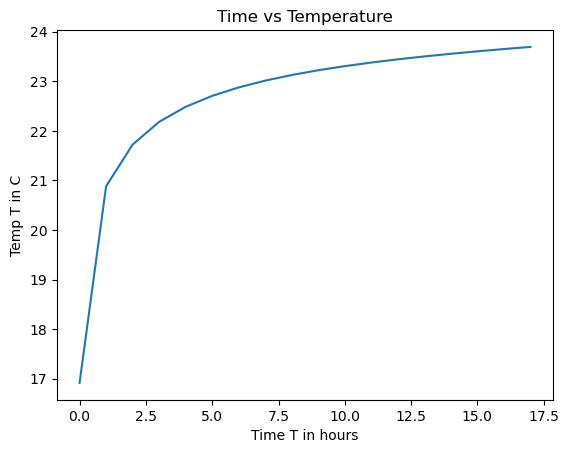

In [158]:
def tAtXandT(cn, z, a, t, l):
    xS = 1   
    fo =  a * t / l
    value = (cn * np.exp(-z**2 * fo) * np.cos(z*xS))     
    return value

minWoolTvst = []
co2Tvst= []
for t in range(0,64800,3600):
    theta = 0.0
    for i in range (0,15):
        theta = theta + tAtXandT(CN[i], uniqueRoots[i], minWool_Diff, t, minWool_t)
    minWoolTvst.append((minWool_tempInit - amb_temp)*theta + amb_temp)

plt.plot(minWoolTvst)
plt.title('Time vs Temperature')
plt.xlabel('Time T in hours')
plt.ylabel('Temp T in C')

In [59]:
# fo = 1/2
# nodalDist = 10e-3
# timeStep = fo * (nodalDist**2) / minWool_Diff
# q_outerFlux = amb_h/(abs(minWool_tempInit - amb_temp))
# bi = amb_h * nodalDist / minWool_k